In [1]:
import ultralytics

In [1]:
print("ola mundo")

ola mundo


### Contagem de fotos e Bounding Box placa de carros.

In [ ]:
# Quantidade de fotos para o treinamento da V6
import os
initial_count_picture = 0
dir_picture = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images'
for path in os.listdir(dir_picture):
    if os.path.isfile(os.path.join(dir_picture, path)):
        initial_count_picture += 1
print(f'Quantidade de fotos para o treinamento: {initial_count_picture}')

initial_count_picture = 0
dir_picture = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/test/images'
for path in os.listdir(dir_picture):
    if os.path.isfile(os.path.join(dir_picture, path)):
        initial_count_picture += 1
print(f'Quantidade de fotos para o teste: {initial_count_picture}')

initial_count_file = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/labels'
for path in os.listdir(dir_labels):
    if os.path.isfile(os.path.join(dir_labels, path)):
        initial_count_file += 1
print(f'Quantidade de arquivos .txt para o treinamento: {initial_count_file}')

initial_count_file = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/test/labels'
for path in os.listdir(dir_labels):
    if os.path.isfile(os.path.join(dir_labels, path)):
        initial_count_file += 1
print(f'Quantidade de arquivos .txt para o teste: {initial_count_file}')

initial_count_line = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/labels'
src_files = os.listdir(dir_labels)
for txt in src_files:
    i = open(f'/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/labels/{txt}')
    j = len(i.readlines())
    initial_count_line = initial_count_line + j
print(f'Quantidade de bounding-box para o treinamento: {initial_count_line}')

initial_count_line = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/test/labels'
src_files = os.listdir(dir_labels)
for txt in src_files:
    i = open(f'/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/test/labels/{txt}')
    j = len(i.readlines())
    initial_count_line = initial_count_line + j
print(f'Quantidade de bounding-box para o teste: {initial_count_line}')

Quantidade de fotos para o treinamento: 400
Quantidade de fotos para o teste: 2
Quantidade de arquivos .txt para o treinamento: 400
Quantidade de arquivos .txt para o teste: 2
Quantidade de bounding-box para o treinamento: 406
Quantidade de bounding-box para o teste: 2


## Imagens alfabeto e numeros

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KlDA6OFRek6U1PSXHzUg")
project = rf.workspace("new-workspace-ckm0b").project("alphabet-extended")
version = project.version(1)
dataset = version.download("yolov8")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.52, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to alphabet-extended-1 in yolov8::  81%|████████  | 5759/7126 [00:02<00:00, 2711.20it/s]

### Transferindo arquivos para o drive

In [ ]:
import shutil

source_dir = r"/content/alphabet-extended-1"

destination_dir = r"/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended"

# Add the dirs_exist_ok=True parameter to allow overwriting
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

### Contagem de fotos e Bounding Box numeros e alfabeto.

In [ ]:
# Quantidade de fotos para o treinamento da V6
import os
initial_count_picture = 0
dir_picture = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/train/images'
for path in os.listdir(dir_picture):
    if os.path.isfile(os.path.join(dir_picture, path)):
        initial_count_picture += 1
print(f'Quantidade de fotos para o treinamento: {initial_count_picture}')

initial_count_picture = 0
dir_picture = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/test/images'
for path in os.listdir(dir_picture):
    if os.path.isfile(os.path.join(dir_picture, path)):
        initial_count_picture += 1
print(f'Quantidade de fotos para o teste: {initial_count_picture}')

initial_count_file = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/train/labels'
for path in os.listdir(dir_labels):
    if os.path.isfile(os.path.join(dir_labels, path)):
        initial_count_file += 1
print(f'Quantidade de arquivos .txt para o treinamento: {initial_count_file}')

initial_count_file = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/test/labels'
for path in os.listdir(dir_labels):
    if os.path.isfile(os.path.join(dir_labels, path)):
        initial_count_file += 1
print(f'Quantidade de arquivos .txt para o teste: {initial_count_file}')

initial_count_line = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/train/labels'
src_files = os.listdir(dir_labels)
for txt in src_files:
    i = open(f'/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/train/labels/{txt}')
    j = len(i.readlines())
    initial_count_line = initial_count_line + j
print(f'Quantidade de bounding-box para o treinamento: {initial_count_line}')

initial_count_line = 0
dir_labels = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/test/labels'
src_files = os.listdir(dir_labels)
for txt in src_files:
    i = open(f'/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/test/labels/{txt}')
    j = len(i.readlines())
    initial_count_line = initial_count_line + j
print(f'Quantidade de bounding-box para o teste: {initial_count_line}')

## Treinamento de placa de carros

In [ ]:
# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

# !yolo train model=yolov8m.pt data='/content/drive/MyDrive/yolo/yolov5/data/dataset/dataset.yaml' epochs=300 imgsz=640
model = YOLO('yolov8x.pt')  # load a pretrained YOLOv8n detection model
model.train(data='/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/data.yaml', epochs=20, imgsz=640, batch=16)  # train the model
#model('https://ultralytics.com/images/bus.jpg')  # predict on an image

In [ ]:
import shutil

source_dir = r"/content/runs"

destination_dir = r"/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs"

shutil.copytree(source_dir, destination_dir)

## Treinamento de numeros e alfabeto

In [ ]:
# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8x.pt')  # load a pretrained YOLOv8n detection model
model.train(data='/content/drive/MyDrive/ColabNotebooks/tcc_mba/alphabet-extended/data.yaml', epochs=10, imgsz=640, batch=16)  # train the model

In [ ]:
import shutil

source_dir = r"/content/runs"

destination_dir = r"/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs_num_alfa"

shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

## Detecção de placa com Yolo

In [ ]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import os
import numpy as np

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs_num_alfa/detect/train/weights/best.pt')

# Função de detecção e salvamento
def detect_and_save(image_path, save_path):
    results = model.predict(source=image_path)
    for result in results:
        annotated_frame = result.plot()
        cv2.imwrite(save_path, annotated_frame)
        if os.path.exists(save_path):
            print(f"Imagem salva com sucesso em {save_path}")
        else:
            print(f"Erro ao salvar a imagem em {save_path}")
    return save_path


# Caminho da imagem e onde salvar a imagem processada
image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/0_augmented_plate.jpg'
save_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/images/predict_al_num.jpg'

plate_img = detect_and_save(image_path, save_path)

## Detecção de placa com pytesseract

In [ ]:
%pip install ultralytics
%pip install opencv-python
%pip install pytesseract
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Implementação Pytesseract

In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
from matplotlib import pyplot as plt
import os
import numpy as np

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs/detect/train2/weights/best.pt')

# Função de detecção e salvamento
def detect_and_save(image_path, save_path):
    results = model.predict(source=image_path)
    for result in results:
        annotated_frame = result.plot()
        cv2.imwrite(save_path, annotated_frame)
        if os.path.exists(save_path):
            print(f"Imagem salva com sucesso em {save_path}")
        else:
            print(f"Erro ao salvar a imagem em {save_path}")
    return save_path


# Função para extrair a região da placa
def extract_plate(image_path):
    results = model(image_path)
    detections = results[0]

    for detection in detections:
        if detection.names[0] == 'placa':
            x_min, y_min, x_max, y_max = map(int, detection.boxes[0].xyxy[0].tolist())
            img = cv2.imread(image_path)
            plate_img = img[y_min:y_max, x_min:x_max]
            return plate_img

    return None

# Função para aplicar OCR na região da placa
def ocr_plate(plate_img, output_dir):

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, (960, 540), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join(output_dir, '0_augmented_plate.jpg'), img_size)

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(output_dir, '1_gray_plate.jpg'), gray_plate)

    # Aplicar desfoque gaussiano para reduzir o ruído
    blurred_plate = cv2.GaussianBlur(gray_plate, (3, 3), 0)
    cv2.imwrite(os.path.join(output_dir, '2_blurred_plate.jpg'), blurred_plate)

    # Aplicar binarização
    _, binary_plate = cv2.threshold(blurred_plate, 130, 255, cv2.THRESH_BINARY)
    cv2.imwrite(os.path.join(output_dir, '4_binary_plate.jpg'), binary_plate)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated_plate = cv2.dilate(binary_plate, kernel, iterations=1)
    cv2.imwrite(os.path.join(output_dir, '5_dilated_plate.jpg'), dilated_plate)

    # Usar Tesseract OCR para extrair o texto
    config = r"-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"
    text = pytesseract.image_to_string(dilated_plate, lang="eng", config=config)

    # Salvar o texto extraído em um arquivo de texto
    with open(os.path.join(output_dir, '6_extracted_text.txt'), 'w') as text_file:
        text_file.write(text)

    return text


# Caminho da imagem e onde salvar a imagem processada
image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-130-_jpg.rf.0a95b15cd4e23d10509bfb361ebe6b99.jpg'
save_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/images/predict.jpg'

# Executar a detecção e salvar a imagem anotada
processed_image_path = detect_and_save(image_path, save_path)

output_dir = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/'

plate_img = extract_plate(image_path)

if plate_img is not None:
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Aplicar OCR na região da placa e salvar cada etapa
    plate_text = ocr_plate(plate_img, output_dir)
    print(f'Texto da placa: {plate_text}')
else:
    print('Nenhuma placa detectada.')

In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
from matplotlib import pyplot as plt
import os
import numpy as np
from google.colab.patches import cv2_imshow

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs/detect/train2/weights/best.pt')

def show_image(img):
    cv2_imshow(img)

# Função para extrair a região da placa
def extract_plate(image_path):
    results = model(image_path)
    detections = results[0]

    for detection in detections:
        if detection.names[0] == 'placa':
            x_min, y_min, x_max, y_max = map(int, detection.boxes[0].xyxy[0].tolist())
            img = cv2.imread(image_path)
            plate_img = img[y_min:y_max, x_min:x_max]
            return plate_img

    return None

# Função para aplicar OCR na região da placa
def ocr_plate(plate_img, output_dir):

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, None, fy=3, fx=3, interpolation=cv2.INTER_CUBIC)
    #cv2.imwrite(os.path.join(output_dir, '0_augmented_plate.jpg'), img_size)
    #show_image(img_size)

    copia = img_size.copy()

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite(os.path.join(output_dir, '1_gray_plate.jpg'), gray_plate)
    #show_image(gray_plate)

    # Aplicar desfoque gaussiano para reduzir o ruído
    blurred_plate = cv2.GaussianBlur(gray_plate, (9, 9), 0)
    #cv2.imwrite(os.path.join(output_dir, '2_blurred_plate.jpg'), blurred_plate)
    #show_image(blurred_plate)

    # Aplicar binarização
    thresh_plate = cv2.adaptiveThreshold(blurred_plate, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)
    #cv2.imwrite(os.path.join(output_dir, '4_binary_plate.jpg'), binary_plate)
    show_image(thresh_plate)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel_place = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

    dilated_place = cv2.dilate(thresh_plate, kernel_place, iterations=6)
    #cv2.imwrite(os.path.join(output_dir, '5_dilated_plate.jpg'), dilated_plate)
    show_image(dilated_place)

    cnts = cv2.findContours(dilated_place, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    line_items_coordinates = []

    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if y <= 100 and x <= 400:
          if area > 1000:
              cv2.rectangle(copia, (x, y), (x + w, y + h), (255, 0, 255), 3)
              roi = dilatsed_place[y-2:y+h+2, x-2:x+w+2]
              #show_image(roi)

              line_items_coordinates.append((x, y, w, h))
              print(f'x: {x}, y: {y}, w: {w}, h: {h}')

    show_image(copia)


# Caminho da imagem e onde salvar a imagem processada
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa-Mercosul-3.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-121-_jpg.rf.f243630c14349ed3de39cb430fb49a34.jpg'
image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-124-_jpg.rf.de69817a7fccbbf4cae5bcd1449c9778.jpg'
output_dir = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/'

plate_img = extract_plate(image_path)
ocr_plate(plate_img, output_dir)

In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
from matplotlib import pyplot as plt
import os
import numpy as np
from google.colab.patches import cv2_imshow

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs/detect/train2/weights/best.pt')

def show_image(img):
    cv2_imshow(img)

# Função para extrair a região da placa
def extract_plate(image_path):
    results = model(image_path)
    detections = results[0]

    for detection in detections:
        if detection.names[0] == 'placa':
            x_min, y_min, x_max, y_max = map(int, detection.boxes[0].xyxy[0].tolist())
            img = cv2.imread(image_path)
            plate_img = img[y_min:y_max, x_min:x_max]
            return plate_img

    return None

# Função para aplicar OCR na região da placa
def ocr_plate(plate_img, output_dir):

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, None, fy=3, fx=3, interpolation=cv2.INTER_CUBIC)
    #cv2.imwrite(os.path.join(output_dir, '0_augmented_plate.jpg'), img_size)
    #show_image(img_size)

    copia = img_size.copy()

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite(os.path.join(output_dir, '1_gray_plate.jpg'), gray_plate)
    #show_image(gray_plate)

    # Aplicar desfoque gaussiano para reduzir o ruído
    blurred_plate = cv2.GaussianBlur(gray_plate, (9, 9), 0)
    #cv2.imwrite(os.path.join(output_dir, '2_blurred_plate.jpg'), blurred_plate)
    #show_image(blurred_plate)

        # Aplicar binarização
    _, binary_plate = cv2.threshold(blurred_plate, 130, 255, cv2.THRESH_BINARY)
    #cv2.imwrite(os.path.join(output_dir, '4_binary_plate.jpg'), binary_plate)
    #show_image(binary_plate)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated_place = cv2.dilate(binary_plate, kernel, iterations=1)
    #cv2.imwrite(os.path.join(output_dir, '5_dilated_plate.jpg'), dilated_plate)
    show_image(dilated_place)

    cnts = cv2.findContours(dilated_place, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    line_items_coordinates = []

    cv2.drawContours(copia, cnts, -1, (0,255,0), 2)
    show_image(copia)

    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if area > 1000:
            cv2.rectangle(copia, (x, y), (x + w, y + h), (255, 0, 255), 3)
            roi = dilated_place[y-2:y+h+2, x-2:x+w+2]
            #show_image(roi)

            line_items_coordinates.append((x, y, w, h))
            print(f'x: {x}, y: {y}, w: {w}, h: {h}')

    show_image(copia)


# Caminho da imagem e onde salvar a imagem processada
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa-Mercosul-3.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-121-_jpg.rf.f243630c14349ed3de39cb430fb49a34.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-124-_jpg.rf.de69817a7fccbbf4cae5bcd1449c9778.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/valid/images/val-92-_jpg.rf.802b468008a8e53a7d862c478cf210a3.jpg'
image_path =  '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-131-_jpg.rf.92b1d6ca3db19b8c6ac3ea59bc072603.jpg'
output_dir = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/'

plate_img = extract_plate(image_path)
ocr_plate(plate_img, output_dir)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# read the image
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/0_augmented_plate.jpg')

def show_image(img):
    cv2_imshow(img)

copia = img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)

conts, hierarquia = cv2.findContours(thresh, cv2.RETR_CCOMP, 2)
show_image(hierarquia)

i=0
placa = ""
for cnt in conts:
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    if 2000 <= area <= 10000:
        cv2.rectangle(copia,(x,y),(x+w,y+h),(0,255,0),3)
        roi = thresh[y-2:y+h+2, x-2:x+w+2]
        show_image(roi)
        if i<4:
            txt = pytesseract.image_to_string(roi, lang='eng', \
            config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
            print(txt)
            placa += txt
        else:
            txt = pytesseract.image_to_string(roi, lang='eng', \
            config='--psm 10 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVXWYZ')
            print(txt)
            placa += txt
        i+=1

show_image(copia)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import re
import pytesseract

# read the image
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/0_augmented_plate.jpg')

def show_image(img):
    cv2_imshow(img)

copia = img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)

contornos, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print(f'Quantidade de contornos: {len(contornos)}')
#cv2.drawContours(copia, contornos, -1, (0,255,0), 2)
#show_image(copia)

# Iterando sobre os contornos encontrados
for contorno in contornos:
    # Ignorando contornos muito pequenos
    if cv2.contourArea(contorno) <= 2000:
        # Obtendo as coordenadas do retângulo que envolve o contorno
        x, y, w, h = cv2.boundingRect(contorno)

        # Desenhando o retângulo na imagem original
        cv2.rectangle(copia, (x, y), (x + w, y + h), (0,0,255),3)

        # Recortando a região de texto da imagem original
        regiao_texto = copia[y:y + h, x:x + w]

        # Aplicando OCR na região de texto
        config = r"tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        texto_detectado = pytesseract.image_to_string(regiao_texto, lang='eng', config=config)  # Use o idioma adequado

        # Imprimindo o texto detectado
        print(f'Texto Detectado: {texto_detectado}')

        # Exemplo de filtragem de caracteres não alfanuméricos
        texto_filtrado = re.sub(r'[^A-Z0-9\s]', '', texto_detectado)
        print(f'Texto Filtrado: {texto_filtrado}')


print(placa[::-1])
show_image(copia)

In [ ]:
# Coordenadas da bounding box
x_min, y_min = 816, 370
x_max, y_max = 945, 411

# Dimensões da imagem (substitua pelos valores reais da sua imagem)
image_width, image_height = 1280, 720

# Calculando o centro da bounding box
center_x = (x_min + x_max) / 2.0
center_y = (y_min + y_max) / 2.0

# Calculando a largura e a altura da bounding box
width = x_max - x_min
height = y_max - y_min

# Normalizando os valores
center_x_normalized = center_x / image_width
center_y_normalized = center_y / image_height
width_normalized = width / image_width
height_normalized = height / image_height

# ID da classe (substitua pelo ID da sua classe)
class_id = 0

# Formato YOLOv8
yolo_format = f"{class_id} {center_x_normalized} {center_y_normalized} {width_normalized} {height_normalized}"
print(yolo_format)

## Implementação redução do tamanho da placa pytesseract


image 1/1 /content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-475-_jpg.rf.211bad2b75002912191be89e2abceb1d.jpg: 640x640 1 placa, 4330.6ms
Speed: 3.3ms preprocess, 4330.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


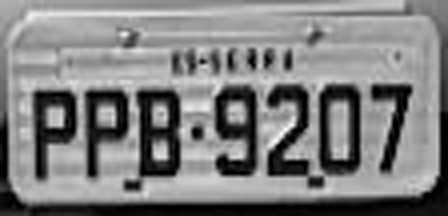

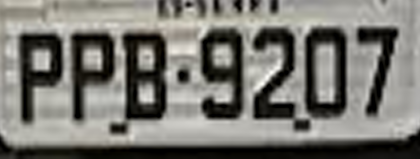

x: 14, y: 57, w: 420, h: 159, text: PPB9207



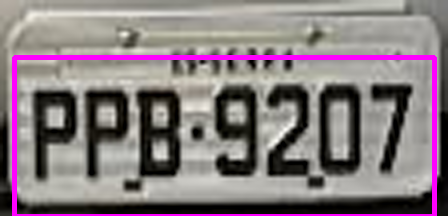

In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
import os
import numpy as np
from google.colab.patches import cv2_imshow

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs/detect/train2/weights/best.pt')

def show_image(img):
    cv2_imshow(img)

# Função para extrair a região da placa
def extract_plate(image_path):
    results = model(image_path)
    detections = results[0]

    for detection in detections:
        if detection.names[0] == 'placa':
            x_min, y_min, x_max, y_max = map(int, detection.boxes[0].xyxy[0].tolist())
            img = cv2.imread(image_path)
            plate_img = img[y_min:y_max, x_min:x_max]
            return plate_img

    return None

# Função para aplicar OCR na região da placa
def ocr_plate(plate_img, output_dir):

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, None, fy=4, fx=4, interpolation=cv2.INTER_CUBIC)
    copia = img_size.copy()

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated_place = cv2.dilate(gray_plate, kernel, iterations=1)
    show_image(dilated_place)

    cnts, _ = cv2.findContours(dilated_place, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    line_items_coordinates = []

    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if area > 40000:
            # Ajuste os valores de redução conforme necessário
            reduction_factor = 0.09

            new_w = int(w * (1.028 - reduction_factor))
            new_h = int(h * (0.83 - reduction_factor))

            # Calcular as novas coordenadas para manter a ROI centralizada
            new_x = x + (w - new_w) // 2
            new_y = y + (h - new_h) // 1

            # Certifique-se de que as novas coordenadas estejam dentro dos limites da imagem
            new_x = max(new_x, 0)
            new_y = max(new_y, 0)
            new_w = min(new_w, img_size.shape[1] - new_x)
            new_h = min(new_h, img_size.shape[0] - new_y)

            cv2.rectangle(copia, (new_x, new_y), (new_x + new_w, new_y + new_h), (255, 0, 255), 3)
            roi = img_size[new_y:new_y+new_h, new_x:new_x+new_w]  # Recorte a região de interesse (ROI) da imagem original
            show_image(roi)

            # Usar Tesseract OCR para extrair o texto da ROI
            config = r"-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"
            text = pytesseract.image_to_string(roi, lang="eng", config=config)

            line_items_coordinates.append((new_x, new_y, new_w, new_h))
            print(f'x: {new_x}, y: {new_y}, w: {new_w}, h: {new_h}, text: {text}')

            # Salvar o texto extraído em um arquivo de texto
            with open(os.path.join(output_dir, f'extracted_text_{new_x}_{new_y}.txt'), 'w') as text_file:
                text_file.write(text)

    show_image(copia)

# Caminho da imagem e onde salvar a imagem processada
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa-Mercosul-3.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-121-_jpg.rf.f243630c14349ed3de39cb430fb49a34.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-124-_jpg.rf.de69817a7fccbbf4cae5bcd1449c9778.jpg'
#image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/valid/images/val-92-_jpg.rf.802b468008a8e53a7d862c478cf210a3.jpg'
image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-131-_jpg.rf.92b1d6ca3db19b8c6ac3ea59bc072603.jpg'
#image_path =  '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-475-_jpg.rf.211bad2b75002912191be89e2abceb1d.jpg'
output_dir = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/'

plate_img = extract_plate(image_path)
if plate_img is not None:
    ocr_text = ocr_plate(plate_img, output_dir)
else:
    print('Nenhuma placa detectada.')



image 1/1 /content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-131-_jpg.rf.92b1d6ca3db19b8c6ac3ea59bc072603.jpg: 640x640 1 placa, 4575.7ms
Speed: 6.2ms preprocess, 4575.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


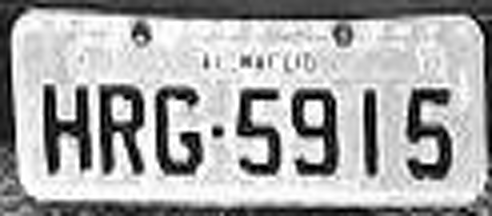

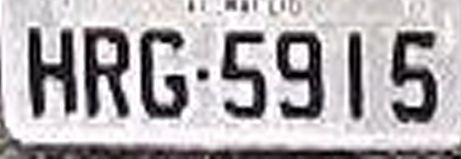

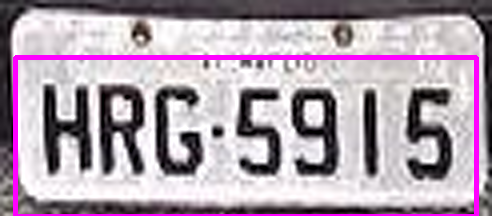

In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
import os
import numpy as np
from google.colab.patches import cv2_imshow

model = YOLO('/content/drive/MyDrive/ColabNotebooks/tcc_mba/treinamento/runs/detect/train2/weights/best.pt')

def show_image(img):
    cv2_imshow(img)

# Função para extrair a região da placa
def extract_plate(image_path):
    results = model(image_path)
    detections = results[0]

    for detection in detections:
        if detection.names[0] == 'placa':
            x_min, y_min, x_max, y_max = map(int, detection.boxes[0].xyxy[0].tolist())
            img = cv2.imread(image_path)
            plate_img = img[y_min:y_max, x_min:x_max]
            return plate_img

    return None

# Função para aplicar OCR na região da placa
def recorte_plate(plate_img, output_dir):

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, None, fy=4, fx=4, interpolation=cv2.INTER_CUBIC)
    copia = img_size.copy()

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated_place = cv2.dilate(gray_plate, kernel, iterations=1)
    show_image(dilated_place)

    cnts, _ = cv2.findContours(dilated_place, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    line_items_coordinates = []

    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if area > 40000:
            # Ajuste os valores de redução conforme necessário
            reduction_factor = 0.09

            new_w = int(w * (1.028 - reduction_factor))
            new_h = int(h * (0.83 - reduction_factor))

            # Calcular as novas coordenadas para manter a ROI centralizada
            new_x = x + (w - new_w) // 2
            new_y = y + (h - new_h) // 1

            # Certifique-se de que as novas coordenadas estejam dentro dos limites da imagem
            new_x = max(new_x, 0)
            new_y = max(new_y, 0)
            new_w = min(new_w, img_size.shape[1] - new_x)
            new_h = min(new_h, img_size.shape[0] - new_y)

            cv2.rectangle(copia, (new_x, new_y), (new_x + new_w, new_y + new_h), (255, 0, 255), 3)
            roi = img_size[new_y:new_y+new_h, new_x:new_x+new_w]  # Recorte a região de interesse (ROI) da imagem original
            show_image(roi)

            cv2.imwrite(os.path.join(output_dir, 'roi.jpg'), roi)

    show_image(copia)

# Caminho da imagem e onde salvar a imagem processada
image_path = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/Placa de carro.v3i.yolov8-obb/train/images/treino-131-_jpg.rf.92b1d6ca3db19b8c6ac3ea59bc072603.jpg'
plate_img = extract_plate(image_path)
if plate_img is not None:
    recorte_plate(plate_img, output_dir)
else:
    print('Nenhuma placa detectada.')

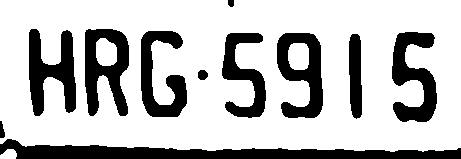

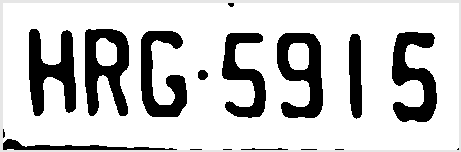

x: 0, y: 0, w: 461, h: 152, text: HRGS915



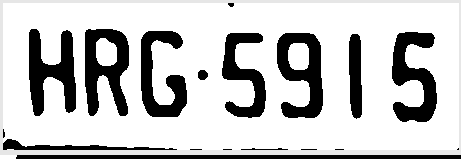

In [ ]:
# Função para aplicar OCR na região da placa
# https://www.michelpf.dev/python/vis%C3%A3o%20computacional/2020/01/10/como-extrair-a-placa-de-um-veiculo-utilizando-viso-computacional.html
def ocr_plate(plate_img,output_dir):

    plate_img = cv2.imread(plate_img) # Load image from file path
    copia = plate_img.copy()

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    # Aplicar desfoque gaussiano para reduzir o ruído
    blurred_plate = cv2.GaussianBlur(gray_plate, (15, 15), 0)

    # Aplicar binarização
    _, binary_plate = cv2.threshold(blurred_plate, 120, 255, cv2.THRESH_BINARY)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated_place = cv2.dilate(binary_plate, kernel, iterations=1)
    show_image(dilated_place)

    cnts, _ = cv2.findContours(dilated_place, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    line_items_coordinates = []

    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if area > 20000:
            cv2.rectangle(dilated_place, (x, y), (x + w, y + h), (230, 185, 245), 3)
            roi = dilated_place[y:y+h, x:x+w]  # Recorte a região de interesse (ROI) da imagem original
            show_image(roi)

            # Usar Tesseract OCR para extrair o texto da ROI
            config = r"-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"
            text = pytesseract.image_to_string(roi, lang="eng", config=config)

            line_items_coordinates.append((x, y, w, h))
            print(f'x: {x}, y: {y}, w: {w}, h: {h}, text: {text}')

            # Salvar o texto extraído em um arquivo de texto
            with open(os.path.join(output_dir, f'extracted_text_{x}_{y}.txt'), 'w') as text_file:
                text_file.write(text)

    show_image(dilated_place)

plate_img = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/roi.jpg'
output_dir = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/predict/processing_steps/'

ocr_plate(plate_img, output_dir)